In [71]:
# 1. IMPORTS
# ==========================================
# %matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import re
import missingno as msno
import os
from IPython.display import display, Markdown, HTML

In [72]:
# 2. DICTIONARIES AND LISTS
# ==========================================

# * These dictionaries and lists act as the "Medical Brain" of the script. 

# Separating logic from data allows non-coders to update clinical criteria easily.
class ClinicalConfig:
    """
    Centralized configuration object acting as the 'Medical Brain'.
    Encapsulates all clinical dictionaries, regex patterns, decision boundaries,
    and biological sanity checks.
    """
    def __init__(self):
        # 1. Variable Categorization
        self.categories = {
            "Demographics/Vitals": ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate'],
            "Medications": ['Medications'],
            "Clinical Context": ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure'],
            "Structural Echo (Dimensions)": ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium'],
            "Functional Echo (Hemodynamics)": ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']
        }

        # 2. Severity & Scoring Maps
        self.severity = {
            'critical': 3.5, 'severe to critical': 3.25, 'severe': 3.0,
            'moderate to severe': 2.5, 'moderate': 2.0, 'mild to moderate': 1.5,
            'mild': 1.0, 'none': 0.0
        }
        
        self.lvef_values = {
            'Hyperdynamic': 70.0, 'Normal': 60.0, 'Borderline': 50.0,
            'Moderately reduced': 40.0, 'Reduced': 25.0
        }
        
        self.echo_severity = {'trace': 15.0, 'mild': 20.0, 'none': 10.0}

        # 3. Pattern Recognition (Regex Targets)
        self.procedures = {
            "Surgical" : ['replacement', 'repair', 'patch', 'graft'],
            "Percutaneous" : ['percutaneous valvuloplasty', 'closure', 'stent', 'ablation']
        }

        self.pathology_patterns = {
            'MS': ['mitral stenosis'],
            'MR': ['mitral regurgitation'],
            'AS':  ['aortic stenosis'],
            'AR': ['aortic regurgitation'],
            'PH': ['pulmonary hypertension'],
            'Septal': ['Secundum atrial septal defect', 'Perimembranous ventricular septal defect', 
                       'Ventricular septal defect', 'Incomplete atrioventricular septal defect', 'Sinus venosus atrial septal defect']
        }
        
        self.la_patterns = {
            4.0: r'(?:huge|severely|severe)',
            2.5: r'(?:moderately|moderate)',
            1.0: r'(?:mild)'
        }

        # 4. Pharmacological Knowledge Base
        self.medication_classes = {
            'Beta_Blockers': ['Carvedilol', 'Bisoprolol', 'Propranolol', 'Metoprolol', 'Atenolol'],
            'RAAS_Inhibitors': ['Enalapril', 'Lisinopril', 'Losartan', 'Valsartan', 'Irbesartan', 'Captopril', 'Sacubitril-valsartan'],
            'Diuretics_Loop': ['Furosemide'],
            'Diuretics_Other': ['Spironolactone', 'Espironolactone', 'Hydrochlorothiazide'],
            'Anticoagulants_Antiplatelets': ['Warfarin', 'Warfarine', 'Rivaroxaban', 'Apixaban', 'Aspirin', 'Clopidogrel'],
            'Rate_Rhythm_Control': ['Digoxin', 'Amiodarone'],
            'Calcium_Channel_Blockers': ['Nifedipine', 'Amlodipine'],
            'SGLT2_Inhibitors': ['Dapaglifozin', 'Empaglifozin'],
            'Pulmonary_Vasodilators': ['Sildenafil', 'Tadalafil'],
            'Lipid_Lowering': ['Simvastatin', 'Rosuvastatin', 'Rosuvastatine', 'Gemfibrozil', 'Ciprofibrate'],
            'Anti_Ischemic_Other': ['Trimetazidine', 'Ranolazine'],
            'Metabolic_Endocrine': ['Levothyroxine', 'Metformin']
        }

        self.freq_day = {'qd': 1, 'bid': 2, 'tid': 3, 'qid': 4}

        self.max_doses = {
            'Sacubitril-valsartan': 400.0, 'Enalapril': 40.0, 'Lisinopril': 40.0, 'Losartan': 100.0,
            'Valsartan': 320.0, 'Irbesartan': 300.0, 'Captopril': 150.0, 'Carvedilol': 50.0,
            'Bisoprolol': 10.0, 'Metoprolol': 200.0, 'Atenolol': 100.0, 'Propranolol': 160.0,
            'Furosemide': 80.0, 'Spironolactone': 50.0, 'Hydrochlorothiazide': 25.0,
            'Sildenafil': 60.0, 'Tadalafil': 40.0, 'Digoxin': 0.25, 'Amiodarone': 400.0,
            'Warfarin': 5.0, 'Rivaroxaban': 20.0, 'Apixaban': 10.0, 'Aspirin': 100.0,
            'Clopidogrel': 75.0, 'Nifedipine': 90.0, 'Amlodipine': 10.0, 'Trimetazidine': 70.0,
            'Ranolazine': 1000.0, 'Dapaglifozin': 10.0, 'Empaglifozin': 25.0, 'Metformin': 2000.0,
            'Levothyroxine': 0.2, 'Simvastatin': 40.0, 'Rosuvastatin': 40.0, 'Gemfibrozil': 1200.0,
            'Ciprofibrate': 100.0
        }

        self.class_weights = {
            'Diuretics_Loop': 3.0, 'Pulmonary_Vasodilators': 3.0, 'RAAS_Inhibitors': 2.0,
            'SGLT2_Inhibitors': 2.0, 'Diuretics_Other': 2.0, 'Beta_Blockers': 2.0,
            'Rate_Rhythm_Control': 1.0, 'Anticoagulants_Antiplatelets': 1.0,
            'Calcium_Channel_Blockers': 1.0, 'Anti_Ischemic_Other': 1.0,
            'Lipid_Lowering': 0.5, 'Metabolic_Endocrine': 0.5
        }

        # 5. Analysis Groupings
        self.echo_groups = {
            "Mitral": {"Parameters": ['MS MG (mmHg)', 'Left atrium', 'LVIDd', 'LVIDs'], "Severity_Cols": ['Sev_MS', 'Sev_MR']},
            "Aortic": {"Parameters": ['AO V1 max', 'AO V2 max', 'Aortic root', 'IVSd', 'LVPWd'], "Severity_Cols": ['Sev_AS', 'Sev_AR']},
            "PH": {"Parameters": ['RVSP', 'TR Vmax'], "Severity_Cols": ['Sev_PH']}
        }

        # 6. Statistical Baselines & Sanity Checks
        self.normal_variables = {
            'MS MG (mmHg)': (1.5, 0.5),
            'AO V2 max': (1.1, 0.2),
            'RVSP': (25.0, 4.0),
            'LVIDd': (4.6, 0.4)
        }

        self.echo_vars = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'Left atrium', 'LVIDd', 'LVEF (categorical)']
        self.echo_missing = ['MS MG (mmHg)', 'AO V2 max', 'RVSP', 'LVIDd']
        self.clinical_markers = ['Mixed_Mitral', 'Mixed_Aortic', 'Multi_Valve', 'PH_Significant', 'AFib_Present']
        self.lesions_anatomic = ['Sev_MS','Sev_MR','Sev_AS','Sev_AR', 'Sev_PH']

In [73]:
# 3. CLASSES AND FUNCTIONS
# ==========================================

class Auditor:
    """
    Acts as the 'Quality Control' station. 
    Before any analysis, we must identify 'Missing Not At Random' (MNAR) patterns 
    often caused by limited time during medical brigades.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def report(self):
        """
        Generates a 3-part audit: 
        1. Technical metadata.
        2. Clinical category missingness (shows which exam parts were skipped).
        3. Lexicon extraction (identifies unique raw strings for manual review).
        """
        audit = []
        for col in self.df.columns:
            audit.append({
                'Column': col,
                'Inferred dtype': self.df[col].dtype,
                'Null Count': self.df[col].isnull().sum(),
                'Sample Values': self.df[col].dropna().unique()[:3].tolist()
            })
            
        # Clinical NLP: Extracting the vocabulary used by the doctors in the field.
        all_diagnoses = pd.concat([
            self.df['Pre-procedure diagnosis'],
            self.df['Post-procedure diagnosis']
        ]).str.split(',').explode().str.strip().dropna().unique()

        all_medications = self.df['Medications'].str.split('|').explode().str.strip().dropna()
        medications_unique = all_medications.str.split(' ').str[0].str.capitalize().unique()

        # Reporting Missingness by Clinical Grouping
        print(f"Current columns by category:\n{'-'*40}")
        for category, cols in self.config.categories.items():
            print(f"{category}: {cols}")

        group_report = {}
        missing_from_categories = []

        for group, cols in self.config.categories.items():
            # Checks if our expected columns actually exist in the CSV header
            not_found = [c for c in cols if c not in self.df.columns]
            found = [c for c in cols if c in self.df.columns]

            # This logs missing columns
            if not_found:
                missing_from_categories.extend(not_found)
                print(f"\nWarning in {group}: Missing from CSV: {not_found}")
                
            # This calculates mean missingness for found columns
            if found:
                avg_miss = self.df[found].isnull().mean().mean() * 100
                group_report[group] = f"{avg_miss:.2f}% missing"
            else:
                group_report[group] = "N/A - No columns found"

        print("\nMean missingness by category (%):")
        print(f"{'-'*40}")
        print(pd.Series(group_report))

        # Persistence: Ensuring we have an 'Audit Trail' for clinical accountability.
        audit_df = pd.DataFrame(audit)
        pd.DataFrame({'All_diagnoses_list': all_diagnoses}).to_csv('all_diagnoses_report.csv', index=False)
        pd.DataFrame({'All_medications_list': medications_unique}).to_csv('all_medications_report.csv', index=False)
        audit_df.to_csv('dataset_audit_report.csv', index=False)

        print('\nAudit report generated:\n' + f"{'-'*40}")
        print('Technical metadata file generated: dataset_audit_report.csv. ')
        print('All unique diagnoses list generated: all_diagnoses_report.csv.')
        print('All medications list generated: all_medications_report.csv.')
        return audit_df
        
    def echo_missingness(self):
        """
        Forensic Data Audit: 
        Calculates completion rates (%) per column, stratified by 
        disease severity and clinical grouping.
        """
        results = []
        
        # Access the injected echo_groups_dict
        for unit, groups in self.config.echo_groups.items():
            for sev_col in groups["Severity_Cols"]: 
                if sev_col not in self.df.columns:
                    continue
                
                for sev_level in sorted(self.df[sev_col].unique()):
                    subset = self.df[self.df[sev_col] == sev_level]
                    if subset.empty: continue
                    
                    for param in groups["Parameters"]:
                        if param in self.df.columns:
                            completeness = (1 - subset[param].isnull().mean()) * 100
                            results.append({
                                'Pathology': sev_col.replace('Sev_', ''),
                                'Severity': sev_level,
                                'Parameter': param,
                                'Completeness_Pct': round(completeness, 2),
                                'N': len(subset)
                            })
                            
        missings_stratified = pd.DataFrame(results)

        # Pivot for 'Missingness Matrix' visualization. 
        pivot_audit = missings_stratified.pivot_table(
            index=['Pathology', 'Parameter'], 
            columns='Severity', 
            values='Completeness_Pct' 
        )
        
        print("Missingness pivot table" + "\n" + "-"*40)
        print("Rows: Pathology-Parameter pairs")
        print("Columns: Clinical Severity (0.0 to 3.5)\n")
        return pivot_audit

class Extractor:
    """
    The 'Refinery'. Transforms messy clinical strings into 'Tidy' structured data.
    Key philosophy: Do not oversimplify. Preserve mixed valvular disease signatures.
    """
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config
        self.severities = list(self.config.severity.keys())
        # Regex to strip intensity
        self.strip_pattern = r'\b(' + '|'.join(self.severities) + r')\b'

    def _get_expanded_diag(self, col_name):
        """Handles comma-separated lists in a single cell."""
        return self.df[col_name].str.lower().str.split(',').explode().str.strip().dropna()

    def _clean_column(self, col):
        """Standardizes anatomy by removing qualitative noise and surgical terms."""
        s = self._get_expanded_diag(col)
        cleaned = s.str.replace(self.strip_pattern, '', regex=True) \
            .str.replace(r'\s+', ' ', regex=True) \
            .str.strip() \
            .str.capitalize()
        
        # Group back to original rows to maintain 1:1 patient mapping.
        return cleaned.groupby(level=0).agg(lambda x: ', '.join(x.unique()) if x.any() else np.nan)

    def _parse_meds(self, med_string, drug_list):
        """
        Pharmacological Parser:
        Identifies drug, extracts base dose, and applies frequency multipliers (e.g., bid=x2).
        """
        if pd.isna(med_string) or med_string == "":
            return "None", 0.0
            
        individual_meds = [m.strip().lower() for m in str(med_string).split('|')]
        
        for med_entry in individual_meds:
            matched_drug = next((d for d in drug_list if d.lower() in med_entry), None)
            
            if matched_drug:
                # Extract dose number (handles decimals like 6.25)
                dose_match = re.search(r'(\d+\.?\d*)', med_entry)
                base_dose = float(dose_match.group(1)) if dose_match else 0.0
                
                # Determine frequency multiplier
                multiplier = 1 
                for freq, value in self.config.freq_day.items():
                    if f" {freq}" in f" {med_entry}":
                        multiplier = value
                        break
                
                return matched_drug.capitalize(), base_dose * multiplier
                
        return "None", 0.0

    def transform(self):
        """
        Main orchestration of the feature engineering process.
        Creates a multidimensional lesion matrix (e.g., separate columns for MS and MR severity).
        """
        # 1. Anatomy Extraction (The 'What' is involved)
        self.df['Anatomy_Pre'] = self._clean_column('Pre-procedure diagnosis')
        self.df['Anatomy_Post'] = self._clean_column('Post-procedure diagnosis')

        # 2. Multidimensional Severity Mapping (The 'How Bad' is it?)
        def severity_score(text_series, path_regex):
            entries = str(text_series).lower().split(',')
            for entry in entries:
                if re.search(path_regex, entry):
                    for label, score in self.config.severity.items():
                        if label in entry: return score
            return 0.0

        for lesion, keywords in self.config.pathology_patterns.items():
            col_name = f'Sev_{lesion}'
            pattern = '|'.join(keywords) 
            self.df[col_name] = self.df['Pre-procedure diagnosis'].fillna('').apply(
                lambda x: severity_score(x, pattern)
            )

        # 3. Procedural Classification (The 'Approach')
        self.df['Approach'] = 'Native'
        post_exploded = self._get_expanded_diag('Post-procedure diagnosis')
        
        for group, keywords in self.config.procedures.items():
            pattern = '|'.join(keywords)
            idx = post_exploded[post_exploded.str.contains(pattern, regex=True, na=False)].index
            self.df.loc[idx, 'Approach'] = group

        # 4. Pharmacological Quantification
        for category, drugs in self.config.medication_classes.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            # Use the internal _parse_meds method with injected freq_day
            self.df[[name_col, dose_col]] = self.df['Medications'].apply(
                lambda x: pd.Series(self._parse_meds(x, drugs))
            )

        # 5. Left Atrium Size Scoring
        self.df['LA_Size_Score'] = 0.0
        self.df['LA_Thrombus'] = 0.0
        self.df['LA_Mass'] = 0.0
        
        for score, pattern in self.config.la_patterns.items():
            # Only update if current score is lower (preserves the highest severity found)
            mask = self.df['Left atrium'].str.contains(pattern, case=False, na=False, regex=True)
            self.df.loc[mask, 'LA_Size_Score'] = np.maximum(self.df.loc[mask, 'LA_Size_Score'], score)

        # 6. Pathological Findings (Flags)
        # Thrombus/Clot/Smoke (Spontaneous Echo Contrast)
        self.df['LA_Thrombus'] = self.df['Left atrium'].str.contains(r'(?:thrombus)', case=False, na=False, regex=True).astype(int)

        # Masses (Myxomas)
        self.df['LA_Mass'] = self.df['Left atrium'].str.contains(r'(?:myxoma)', case=False, na=False, regex=True).astype(int)
        
        # 6. Normalization of echo 
        for col in self.config.echo_missing:
            if col in self.df.columns:
                # 1. Convert to string and handle whitespace
                # We use .str.strip() to catch hidden spaces like " 25 "
                s = self.df[col].astype(str).str.lower().str.strip()
                
                # 2. Replace qualitative terms (trace, mild) with your dictionary
                s = s.replace(self.config.echo_severity)
                
                # 3. Final Coercion
                # If a value was "45mm", pd.to_numeric turns it to NaN. 
                # If your data has "mm" in it, we must strip it first.
                s = s.str.extract(r'(\d+\.?\d*)')[0] # Remove all non-numeric chars
                
                self.df[col] = pd.to_numeric(s, errors='coerce').round(1)

        # 7. LVEF Numerical Mapping
        # We use .str.title() to match 'Normal', 'Reduced', etc. 
        if 'LVEF (categorical)' in self.df.columns:
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().str.title().map(self.config.lvef_values)
            
            # Clinical Safety Check: If "Moderately reduced" has a lowercase 'r', 
            # title() makes it "Moderately Reduced". We adjust the map or use a lambda.
            # Best practice: 
            self.df['LVEF_Score'] = self.df['LVEF (categorical)'].str.strip().map(
                {k: v for k, v in self.config.lvef_values.items()} # Direct map
            ).fillna(self.df['LVEF (categorical)'].str.strip().str.capitalize().map(self.config.lvef_values))
            
        return self.df

    def baseline(self):
        """
        Generates a Table of demographics and vitals.
        Calculates Mean ± SD for continuous and N (%) for categorical.
        """
        stats = []
        vitals = self.config.categories.get("Demographics/Vitals", [])

        print("Baseline characteristics\n" + '-'*40)

        for col in vitals:
            if col in self.df.columns:
                # Handles numeric columns (Age, Weight, Vitals)
                if pd.api.types.is_numeric_dtype(self.df[col]):
                    mean_val = self.df[col].mean()
                    std_val = self.df[col].std()
                    null_pct = self.df[col].isnull().mean() * 100
                    stats.append({
                        "Characteristic": col,
                        "Value": f"{mean_val:.1f} ± {std_val:.1f}",
                        "Completeness": f"{100 - null_pct:.1f}%",
                        "Type": "Continuous"
                    })
                # Handles categorical (Gender)
                else:
                    top_val = self.df[col].mode()[0] if not self.df[col].mode().empty else "N/A"
                    count = (self.df[col] == top_val).sum()
                    pct = (count / len(self.df)) * 100
                    stats.append({
                        "Characteristic": col,
                        "Value": f"Mode: {top_val} ({pct:.1f}%)",
                        "Completeness": f"{100 - (self.df[col].isnull().mean()*100):.1f}%",
                        "Type": "Categorical"
                    })
                
        return display(pd.DataFrame(stats).set_index("Characteristic"))

    def diagnoses_prevalence(self):
        """Standardizes and counts the global disease burden in the cohort."""
        # Note: transform() must be called before this method to generate Anatomy_Pre
        if 'Anatomy_Pre' not in self.df.columns:
             raise ValueError("Please run transform() first.")
        
        pre = self.df['Anatomy_Pre'].str.split(', ').explode()
        post = self.df['Anatomy_Post'].str.split(', ').explode()
        
        # Combines them and remove 'nan' strings or empty entries
        combined = pd.concat([pre, post])
        combined = combined[~combined.isin(['nan', '', 'None', 'None, None'])]
        
        # Calculate Counts
        counts = combined.value_counts()
        
        # Creates the final Table
        prevalence_df = pd.DataFrame({
            'Patient Count': counts,
            'Prevalence (%)': (counts / len(self.df) * 100).round(1)
        })
        
        prevalence_df.index.name = 'Diagnosis'

        return prevalence_df

    def disease_profiler(self):
        '''
        Identifies complex interactions: Mixed Lesions, Shunts, and Rhythm Confounders.
        '''
        if 'Sev_MS' not in self.df.columns:
             raise ValueError("Please run transform() with required dictionaries before running disease_profiler()")

        # 1. Mixed Valvular Disease (Same-valve: Stenosis + Regurgitation)
        self.df['Mixed_Mitral'] = ((self.df['Sev_MS'] > 0) & (self.df['Sev_MR'] > 0)).astype(int)
        self.df['Mixed_Aortic'] = ((self.df['Sev_AS'] > 0) & (self.df['Sev_AR'] > 0)).astype(int)

        # 2. Multi-Valvular Disease (Cross-valve: Mitral unit AND Aortic unit)
        mitral_any = (self.df['Sev_MS'] > 0) | (self.df['Sev_MR'] > 0)
        aortic_any = (self.df['Sev_AS'] > 0) | (self.df['Sev_AR'] > 0)
        self.df['Multi_Valve'] = (mitral_any & aortic_any).astype(int)

        # 3. Pulmonary Hypertension (Explicit Flag)
        # Defined here as any PH mention (Severity > 0)
        self.df['PH_Present'] = (self.df['Sev_PH'] > 0).astype(int)
        self.df['PH_Significant'] = (self.df['Sev_PH'] >= 2.0).astype(int)

        # 4. Shunts (Septal Defects)
        shunt_pattern = '|'.join(self.config.pathology_patterns['Septal'])
        self.df['Has_Shunt'] = self.df['Pre-procedure diagnosis'].str.contains(
            shunt_pattern, case=False, na=False, regex=True
        ).astype(int)

        # 5. Rhythm Confounders (AFib)
        self.df['AFib_Present'] = self.df['Pre-procedure diagnosis'].str.contains(
            'Atrial fibrillation', case=False, na=False, regex=True
        ).astype(int)

        # 6. Global Complexity Score 
        # Summing binary flags. Note: For PH, we only count it as a 'Complexity Point' 
        # if it is Moderate or worse (>= 2.0), as Mild PH is very common.
        self.df['Complexity_Score'] = (
            self.df['Mixed_Mitral'] + 
            self.df['Mixed_Aortic'] + 
            self.df['Multi_Valve'] + 
            self.df['AFib_Present'] + 
            self.df['PH_Significant']
        )

        # Accurate Prevalence Reporting
        self.complexity_stats = {
            "Total Patients": len(self.df),
            "Mixed Mitral": self.df['Mixed_Mitral'].sum(),
            "Mixed Aortic": self.df['Mixed_Aortic'].sum(),
            "Multi-Valvular": self.df['Multi_Valve'].sum(),
            "Significant PH (>=2.0)": self.df['PH_Significant'].sum(),
            "AFib Present": self.df['AFib_Present'].sum()
        }
        
        return self.df
        
    def complexity_report(self):
        """
        Returns the stats as a clean Pandas Series for easy display or export.
        """
        print("Complex cases\n" + '-'*40)
        print("Cases that have either mixed, multiple valvular disease and/or other conditions\n")
        if hasattr(self, 'complexity_stats'):
            return pd.Series(self.complexity_stats, name="Prevalence")
        else:
            return "Profiler has not been run yet."

class Calculator:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def medication_index(self):
        """
        Computes the Medication Burden Index (MBI).
        MBI = Sum(Class_Weight * (Actual_TDD / Max_TDD))
        """
        self.df['MBI'] = 0.0
        
        for category, weight in self.config.class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            if name_col in self.df.columns:
                # Vectorized calculation for each class
                # Uses 1.0 as a fallback intensity for fixed-dose meds (like Aspirin)
                intensity = self.df.apply(
                    lambda x: x[dose_col] / self.config.max_doses.get(x[name_col], x[dose_col]) 
                    if x[dose_col] > 0 else 0, axis=1
                )
                
                # Clips intensity at 1.0 (to avoid outliers from rare supra-therapeutic doses)
                self.df['MBI'] += (intensity.clip(upper=1.0) * weight)
                
        return self.df
    
class Visualizer:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config
        
    def patient_nullity(self):
        # Forensic Audit: Visualizing data deserts to evaluate mission-specific documentation constraints.
        available_keys = [v for v in self.config.echo_vars if v in self.df.columns]

        # Uses a temporary theme context to ensure the 'Matrix' is readable

        # We use a context manager to temporarily ignore the 'whitegrid' theme
        # which can interfere with missingno's rendering.
        print("Missingness visualizations\n" + '-' *40)
        with plt.style.context('default'):
            plt.figure(figsize=(10, 6))
            msno.matrix(self.df[available_keys], 
                        sparkline=False, 
                        color=(0.1, 0.3, 0.5), # Your dark blue
                        fontsize=10)
            plt.title("Nullity Matrix: Data Presence (Dark) vs Missing (White)", fontsize=14)
            plt.show()

        print("Note: Correlation of Missingness (1.0 = Always missing together):")
        # Heatmap usually works better with a standard context too
        with plt.style.context('default'):
            msno.heatmap(self.df[available_keys], cmap='GnBu')
            plt.title("Missingness Correlation")
            plt.show()

    def echo_matrix(self, table):
        # Triage Efficiency: Quantifying which physiological parameters are deemed 'Critical Path' by the field team.
        print("\nEchocardiogram Triage Matrix notes:" + "\n" + "-"*40)
        print("A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.")
        
        plt.figure(figsize=(14, 10))
        # Using a sequential colormap (YlOrRd) to highlight 'Data Deserts' vs 'Data Oases'.
        sns.heatmap(table.fillna(0), annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Completeness %'})
        plt.title("Echocardiogram Triage Matrix: Data Presence as a Function of Disease Severity", fontsize=15)
        plt.xlabel("Clinician-Assessed Severity (Ordinal Scale)")
        plt.ylabel("Echocardiographic Parameter by Pathology")
        plt.show()

    def complexity_frequency(self):
        """
        Visualizes the phenotypic burden of the cohort.
        """
        plt.figure(figsize=(10, 6))
        
        # Count frequencies of each score
        counts = self.df['Complexity_Score'].value_counts().sort_index()
        
        # Create a bar plot
        sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="YlOrRd", legend=False)
        
        plt.title("Distribution of Patient Complexity Scores", fontsize=15)
        plt.xlabel("Complexity Score (0 = Simple, 5+ = Highly Complex)", fontsize=12)
        plt.ylabel("Number of Patients", fontsize=12)
        
        # Add labels on top of bars
        for i, val in enumerate(counts.values):
            plt.text(i, val + 0.5, str(val), ha='center', fontsize=11, fontweight='bold')
            
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def complexity_markers(self):
        """
        Shows the prevalence of specific complexity markers.
        """
        prevalence = self.df[self.config.clinical_markers].sum().sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        prevalence.plot(kind='barh', color='#e34a33')
        plt.title("Prevalence of Complexity Markers", fontsize=15)
        plt.xlabel("Patient Count", fontsize=12)
        plt.gca().invert_yaxis()
        plt.show()

    def complexity_heatmap(self):
        # Interaction Analysis: Identifying 'Syndromic Clusters' where multiple pathologies co-exist, increasing clinical risk.
        
        # Calculate the correlation (co-occurrence)
        # We use 'pearson' here to see how strongly one predicts the other
        interaction_matrix = self.df[self.config.clinical_markers].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
        
        plt.title("Clinical Interaction Heatmap: Pathological Clustering", fontsize=15)
        plt.tight_layout()
        plt.show()

    def sensitivity_grid(self):
        """
        Generates a 2x2 matrix of KDE plots comparing Measured vs. Imputed data.
        """
        # Identify variables to plot
        plot_vars = [v for v in self.config.echo_missing if v in self.df.columns]
        
        # Create the 2x2 figure (4 subplots)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for i, var in enumerate(plot_vars):
            if i >= 4: break # Limit to 4x4 grid
            
            ax = axes[i]
            imp_col = f"{var}_Imputed"
            
            if imp_col in self.df.columns:
                # Measured Data (The "Sick" Triage Group)
                sns.kdeplot(self.df[var].dropna(), ax=ax, color='red', fill=True, 
                            label='Measured', alpha=0.3)
                
                # Total Cohort (The "Natural Normal" Imputation)
                sns.kdeplot(self.df[imp_col], ax=ax, color='green', linestyle='--', 
                            label='Total Cohort')
                
                ax.set_title(f"{var}: Distribution Shift", fontsize=12, fontweight='bold')
                ax.set_xlabel("Value")
                ax.set_ylabel("Density")
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, f"No Data for {var}", ha='center')

        # Clean up empty subplots if fewer than 4 variables exist
        for j in range(len(plot_vars), 4):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.suptitle("Clinical Sensitivity Matrix: Measured vs. Imputed Populations", 
                    fontsize=14, y=1.02)
        plt.show()

    def validate_vis(self, matrix, x_label, y_label, title):
        plt.figure(figsize=(8,6))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['MBI Low', 'MBI High'], 
                    yticklabels=['Healthy', 'Complex'])
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        print("\nConfusion matrix visualization\n" + '-'*40)
        plt.show()

    def predictor_decomposition(self):
        """
        Generates an interactive horizontal stacked bar chart.
        Shows granular drug dominance and internal percentages.
        """
        composition_data = []

        # 1. Calculation Logic (Parsed from Category/TDD structure)
        for category, weight in self.config.class_weights.items():
            name_col = f"{category}_name"
            dose_col = f"{category}_tdd"
            
            if name_col in self.df.columns and dose_col in self.df.columns:
                valid_rows = self.df[self.df[name_col] != "None"]
                max_doses = valid_rows[name_col].map(self.config.max_doses).fillna(0)
                intensities = (valid_rows[dose_col] / max_doses).clip(upper=1.0)
                burdens = intensities * weight
                
                drug_sums = burdens.groupby(valid_rows[name_col]).sum()
                category_total = drug_sums.sum()

                for drug, burden in drug_sums.items():
                    composition_data.append({
                        'Medication_Class': category,
                        'Specific_Drug': drug,
                        'Burden_Score': burden,
                        'Clinical_Weight': weight,
                        'Percentage_of_Class': (burden / category_total * 100) if category_total > 0 else 0
                    })

        df_comp = pd.DataFrame(composition_data)
        df_comp = df_comp.sort_values(['Clinical_Weight', 'Medication_Class'], ascending=[False, True])

        # 2. Interactive Figure (Colored by Weight with Legend)
        fig = px.bar(
            df_comp, 
            y="Medication_Class", 
            x="Burden_Score", 
            color="Clinical_Weight",  # This creates the Weight-based Legend
            color_continuous_scale=px.colors.diverging.RdBu_r,
            orientation='h',
            title=f"Global MBI Architecture by Clinical Priority (n={len(self.df)})",
            hover_data={
                'Specific_Drug': True,
                'Percentage_of_Class': ':.1f',
                'Burden_Score': ':.2f',
                'Clinical_Weight': True,
                'Medication_Class': False 
            },
            labels={
                'Burden_Score': 'Weighted Burden Contribution',
                'Clinical_Weight': 'Medical Weight Tier'
            },
            template="plotly_white"
        )

        fig.update_layout(
            barmode='stack', 
            height=800,
            yaxis={'categoryorder': 'total ascending'},
            )
        
        print("Global MBI burden, stratified by medication classes\n" + '-'*40)
        display(Markdown("Bars represent **aggregate population burden**    \nColor indicate **clinical priority** weights"))
        fig.show()

        # 3. Automated Key Findings Summary
        self._print_mbi_summary(df_comp)
        
        return df_comp
    
    def _print_mbi_summary(self, df_comp):
        total_mbi = df_comp['Burden_Score'].sum()
    
        # Get Top 3 Classes by total burden
        class_totals = df_comp.groupby('Medication_Class')['Burden_Score'].sum().sort_values(ascending=False).head(3)
        
        print(f"\n{'='*60}\nKEY MBI FINDINGS SUMMARY: PHARMACOLOGICAL DRIVERS\n{'='*60}")
        print(f"Total Cohort Burden Score: {total_mbi:.1f}")
        
        print(f"\nTOP 3 CLINICAL DRIVERS:")
        for i, (category, total) in enumerate(class_totals.items(), 1):
            # Identify the most used medication within this specific class
            class_meds = df_comp[df_comp['Medication_Class'] == category]
            dominant_med = class_meds.loc[class_meds['Burden_Score'].idxmax()]
            
            # Calculate class contribution to global MBI
            global_pct = (total / total_mbi) * 100
            
            print(f"{i}. {category:25} | Burden: {total:5.1f} ({global_pct:4.1f}%)")
            print(f"   - Dominant Medication: {dominant_med['Specific_Drug']} "
                f"({dominant_med['Percentage_of_Class']:.1f}% of class)")
        
        # Gap analysis
        gap_classes = df_comp[df_comp['Burden_Score'] == 0]['Medication_Class'].unique()
        if len(gap_classes) > 0:
            print(f"\nIdentified Care Gaps: No utilization in {len(gap_classes)} high-weight categories.")
        print(f"{'='*60}\n")

    # def hemodynamic_failure(self):
    #     # Plotting RVSP vs MBI to show the 'Refractory Slope'
    #     fig = px.scatter(
    #         self.df[self.df['Approach'] == 'Native'], 
    #         x='MBI', 
    #         y='RVSP_Imputed',
    #         trendline="ols",
    #         marginal_y="violin", 
    #         marginal_x="box",
    #         title="Hemodynamic Failure: RVSP Escaping Medical Control",
    #         labels={'MBI': 'Medication Burden Index', 'RVSP_Imputed': 'Pulmonary Pressure (mmHg)'},
    #         template='plotly_white',
    #         color_discrete_sequence=['#d62728'] # Surgical Red
    #     )
        
    #     # Add a 'High Risk' Threshold line at RVSP = 50
    #     fig.add_hline(y=50, line_dash="dot", line_color="orange", annotation_text="Pulmonary HTN Threshold")
        
    #     fig.show()

class Statistics:
    def __init__(self, dataframe, config):
        self.df = dataframe
        self.config = config

    def impute_normal(self, target_col):
        """
        Implements 'Brigade Logic': Missing values are assumed normal, 
        but filled with Gaussian noise to preserve dataset variance.
        """
        temp_df = self.df.copy()
        temp_df[target_col] = pd.to_numeric(temp_df[target_col], errors='coerce')
        
        mask = temp_df[target_col].isnull()
        num_missing = mask.sum()
        
        mean, std = self.config.normal_variables.get(target_col, (0, 1))
        simulated_normals = np.random.normal(mean, std, size=num_missing).round(1)
        temp_df.loc[mask, target_col] = np.clip(simulated_normals, 0, 150)
                
        return temp_df[target_col]

    def apply_imputation(self):
        for var in self.config.echo_missing:
            if var in self.df.columns:
                # Use 'Natural Normal' to respect Brigade Logic while keeping variance
                self.df[f'{var}_Imputed'] = self.impute_normal(var)
                print(f"Handled {var} using 'Natural Normal' distribution.")

        return self.df
    
    def sensitivity_report(self):
        """
        Creates a succinct summary comparing Measured (Sick) vs. Imputed (Cohort) data.
        """
        summary_data = []
        
        # We only look at variables that were actually imputed
        for var in self.config.echo_missing:
            imp_col = f"{var}_Imputed"
            
            if var in self.df.columns and imp_col in self.df.columns:
                # Data for patients who actually had measurements (The "Red" group)
                measured = self.df[var].dropna()
                
                # Data for the whole cohort after imputation (The "Green" group)
                cohort = self.df[imp_col]
                
                if len(measured) > 0:
                    m_mean = measured.mean()
                    c_mean = cohort.mean()
                    delta = c_mean - m_mean
                    
                    # Clinical Interpretation Logic
                    # If the shift is more than 10% of the measured value, we flag it.
                    bias_status = "Significant Shift" if abs(delta) > (m_mean * 0.1) else "Stable"
                    
                    summary_data.append({
                        "Clinical Parameter": var,
                        "Measured Mean": round(m_mean, 1),
                        "Cohort Mean": round(c_mean, 1),
                        "Delta (Shift)": round(delta, 1),
                        "Triage Bias": bias_status,
                        "Sample Size (n)": len(measured)
                        })

        # Create DataFrame
        report_df = pd.DataFrame(summary_data).set_index("Clinical Parameter")
        return report_df
    
    def roc(self, predictor_col='MBI'):
        """
        Generalized ROC analysis.
        Tests how well a chosen column (predictor_col) predicts Clinical Complexity.
        """
        # Ensures the column exists to avoid a KeyError
        if predictor_col not in self.df.columns:
            print(f"Error: {predictor_col} not found in dataframe.")
            return

        # Redefining Target: Capturing 'Rising Risk' (Score 1 or higher)
        self.df['Is_Complex_Case'] = (self.df['Complexity_Score'] >= 1).astype(int)

        # Recalculate ROC Metrics
        # We drop NAs for the specific predictor to prevent the roc_curve function from failing
        temp_df = self.df[['Is_Complex_Case', predictor_col]].dropna()
        
        fpr, tpr, thresholds = roc_curve(temp_df['Is_Complex_Case'], temp_df[predictor_col])
        roc_auc = auc(fpr, tpr)

        # Finding the Optimal Cutoff using Youden's J statistic
        j_scores = tpr - fpr
        best_idx = np.argmax(j_scores)
        best_cutoff = thresholds[best_idx]

        # Visualization
        print(f"ROC visualization for {predictor_col}\n" + '-'*40)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, color='#e34a33', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='#bdbdbd', linestyle='--', label='Random Classifier')
        
        # Dynamic Label for the Scatter Point
        plt.scatter(fpr[best_idx], tpr[best_idx], color='black', s=100, zorder=5,
                    label=f'Optimal {predictor_col} Cutoff: {best_cutoff:.2f}')

        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        
        # Dynamic Title
        plt.title(f'Predictive Power: {predictor_col} vs. Clinical Complexity', fontsize=14)
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()

        print(f"Analysis Complete: A value of {predictor_col} above {best_cutoff:.2f} is the best predictor of patient complexity.\n")

    def validate_predictor(self, threshold):
        """
        Calculates the F1-Score to validate if MBI > 4.0 
        is a reliable proxy for Anatomical Complexity >= 2.0.
        """
        y_true = self.df['Is_Complex_Anatomic']
        y_pred = self.df['MBI_Predicted_High']
        
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        
        # Portfolio-ready output
        print(f"MBI Threshold Validation (> {threshold})\n" + '-'*40)
        print(f"F1-Score:  {f1:.3f}")
        print(f"Precision: {precision:.3f} (Reliability: When MBI is high, is the patient actually sick?)")
        print(f"Recall:    {recall:.3f} (Sensitivity: Does MBI catch all the sick patients?)")
        cm = confusion_matrix(y_true, y_pred)
        
        return cm 
    
    def _prepare_regression_features(self, df_to_fix):
        # We perform operations on the passed dataframe and return it
        df_to_fix['Gender_Male'] = (df_to_fix['Gender'].str.lower() == 'male').astype(int)
        df_to_fix['Mitral_Mixed_Score'] = df_to_fix['Sev_MS'] * df_to_fix['Sev_MR']
        df_to_fix['Aortic_Mixed_Score'] = df_to_fix['Sev_AS'] * df_to_fix['Sev_AR']
        return df_to_fix

    def run_regression(self, y_var, strata=None, excluded_features=None):
        """
        Modular engine to execute stratified regressions.
        :param y_var: The dependent variable (e.g., 'MBI' or 'RVSP_Imputed')
        :param feature_list: List of predictors to include
        :param strata: Specific 'Approach' to run (e.g., 'Native'). If None, loops all.
        """
        working_df = self.df.copy()

        # 1. Prepare features ONLY on the working copy
        working_df = self._prepare_regression_features(working_df)

        # 2. Ternary switch for strata list
        target_approaches = [strata] if strata else ['Native', 'Percutaneous', 'Surgical']

        # 3. Determine if we are doing a deep dive (single strata selected)
        is_deep_dive = len(target_approaches) == 1   
        
        # 4. Expand the feature list
        demographics = regression_demographics
        lesions = regression_lesions
        echo = regression_echo
        
        features = demographics + lesions + echo
        
        # 2. SILENCING LOGIC: Remove variables the user wants to ignore
        if excluded_features:
            features = [f for f in features if f not in excluded_features]

        # 5. Stratification Logic
        status_results = []
        all_subs = []
        for status in target_approaches:
            # Slices a deep copy for the specific cohort
            sub_df = working_df[working_df['Approach'] == status].copy()
            current_features = [f for f in features if f in self.df.columns and f != y_var]
            
            # Check if we have any features left to run!
            if not current_features:
                print(f"[!] No valid features found for {status}. Skipping.")
                continue

            # Isolate the group
            sub_df = sub_df.dropna(subset=current_features + [y_var])
            
            if len(sub_df) < 15: # Minimum threshold to avoid running on low statistical power
                print(f"\n[!] Stratum '{status}' skipped: Insufficient data (n={len(sub_df)})")
                continue
            
            # Fit Model
            X = sm.add_constant(sub_df[current_features])
            y = sub_df[y_var]
            model = sm.OLS(y, X).fit()
            
            # Attach residuals only to the temporary slice
            sub_df[f'{y_var}_Residual'] = model.resid

            # Store full results for the report
            status_results.append({'status': status, 'model': model, 'n': len(sub_df)})
            all_subs.append(sub_df)

        # Pass the 'status_results' list instead of a single 'status' string
        # Move outside the loop so the Overview can consolidate all results
        if status_results:
            self._print_clinical_report(status_results, y_var, is_deep_dive)

        return pd.concat(all_subs) if all_subs else pd.DataFrame()

    def _print_clinical_report(self, status_results, y_var, is_deep_dive):
        """
        Internal helper to toggle between a clean table and a full summary.
        """
        if is_deep_dive:
            res = status_results[0]
            print(f"\n{'='*40}\nDEEP DIVE: {y_var} {res['status'].upper()} (n={res['n']})\n{'='*40}")
            print(res['model'].summary())
        else:
            # 2. OVERVIEW: Build a Master Comparison Table
            print(f"\n{'='*40}\nCROSS-STRATA COMPARISON: {y_var}\n{'='*40}")

            all_cols = []
            for item in status_results:
                # Extract Params and P-Values
                df_res = pd.concat([item['model'].params, item['model'].pvalues], axis=1)
                df_res.columns = [f"{item['status']} Coef", f"{item['status']} P"]
                
                # Add Significance Stars to the Coef column for readability
                df_res[f"{item['status']} Coef"] = df_res.apply(
                    lambda row: f"{row.iloc[0]:.3f} " + 
                    ('***' if row.iloc[1] < 0.01 else ('**' if row.iloc[1] < 0.05 else '* ' if row.iloc[1] < 0.1 else '')),
                    axis=1
                )
                all_cols.append(df_res[[f"{item['status']} Coef"]]) # Keep only the starred Coef for the table

            # Join all strata columns together
            master_table = pd.concat(all_cols, axis=1).fillna('-')
            
            # Display as a pretty HTML table
            display(HTML(f"<h3>Cohort Coefficient Comparison: {y_var}</h3>"))
            display(master_table)

# --- DRAFT ---

    # def native_deep_dive(self):
    #     # 1. Isolate Native Cohort
    #     native_df = self.df[self.df['Approach'] == 'Native'].copy()
        
    #     # 2. Define Features (Demographics + Vitals + Echo + Interactions)
    #     demographics = self.config.regression_demographics
    #     lesions = self.config.regression_lesions
    #     echo = self.config.regression_echo
        
    #     features = demographics + lesions + echo

    #     # 3. Clean and Fit
    #     df_clean = native_df.dropna(subset=features + ['MBI'])
    #     X = sm.add_constant(df_clean[features])
    #     y = df_clean['MBI']
        
    #     model = sm.OLS(y, X).fit()
        
    #     # 4. Professional Detailed Report
    #     print(f"\n{'='*60}\nDETAILED CLINICAL AUDIT: NATIVE COHORT (n={len(df_clean)})\n{'='*60}")
    #     print(model.summary())
    #     return model
    
    # def calculate_residuals(self):
    #     demographics = self.config.regression_demographics
    #     lesions = self.config.regression_lesions
    #     echo = self.config.regression_echo
        
    #     features = demographics + lesions + echo

    #     results = []
    #     for approach in ['Native', 'Surgical', 'Percutaneous']:
    #         sub = self.df[self.df['Approach'] == approach].dropna(subset=features + ['MBI']).copy()
    #         if len(sub) > 10:
    #             X = sm.add_constant(sub[features])
    #             model = sm.OLS(sub['MBI'], X).fit()
    #             sub['MBI_Mismatch'] = model.resid
    #             results.append(sub)
        
    #     return pd.concat(results)
    
    # def rvsp_hemodynamics(self):
    #     # Focusing on the Native Cohort where the mismatch is highest
    #     native_df = self.df[self.df['Approach'] == 'Native'].copy()
        
    #     # We want to see if MBI acts as a 'Pressure Lowering' force
    #     features_alt_a = [
    #         'MBI', 'Age', 'Weight', 'MS MG (mmHg)_Imputed', 
    #         'AO V2 max_Imputed', 'LVEF_Score', 'LA_Size_Score', 
    #         'Mitral_Mixed_Score', 'Aortic_Mixed_Score'
    #     ]
        
    #     df_clean = native_df.dropna(subset=features_alt_a + ['RVSP_Imputed'])
    #     X = sm.add_constant(df_clean[features_alt_a])
    #     y = df_clean['RVSP_Imputed']
        
    #     model = sm.OLS(y, X).fit()
        
    #     print(f"\n{'='*60}\nHEMODYNAMIC AUDIT: RVSP AS TARGET (Native n={len(df_clean)})\n{'='*60}")
    #     print(model.summary())
    #     return model

In [74]:
# 4. EXECUTION
# ==========================================
# Setup 
config = ClinicalConfig()
load = pd.read_csv('phl_2025.csv')
all_cols = [col for sublist in config.categories.values() for col in sublist]
df = load[load.columns.intersection(all_cols)].copy()

auditor = Auditor(df, config)
extractor = Extractor(df, config)
stats = Statistics(df, config)
calc = Calculator(df, config)
viz = Visualizer(df, config)

In [75]:
# PHASE 1: Baseline Integrity Audit
# ==========================================
print(f"PHASE 1: Baseline Integrity Audit\n{'='*40}")
audit_report = auditor.report()
extractor.transform()
# df[['Sev_AS', 'Sev_AR', 'Sev_MS', 'Sev_MR']]

PHASE 1: Baseline Integrity Audit
Current columns by category:
----------------------------------------
Demographics/Vitals: ['Age', 'Gender', 'Weight', 'Height', 'OSat', 'SBP R', 'DBP R', 'Heart rate']
Medications: ['Medications']
Clinical Context: ['Pre-procedure diagnosis', 'Post-procedure diagnosis', 'Year(s) since procedure']
Structural Echo (Dimensions): ['IVSd', 'LVIDd', 'LVPWd', 'LVIDs', 'Aortic root', 'Left atrium measure', 'Left atrium']
Functional Echo (Hemodynamics): ['LVEF (categorical)', 'RVSP', 'TR Vmax', 'AO V1 max', 'AO V2 max', 'MS MG (mmHg)']

Mean missingness by category (%):
----------------------------------------
Demographics/Vitals                0.58% missing
Medications                        8.55% missing
Clinical Context                  46.05% missing
Structural Echo (Dimensions)      81.77% missing
Functional Echo (Hemodynamics)    66.89% missing
dtype: object

Audit report generated:
----------------------------------------
Technical metadata file generat

,Age,Gender,Pre-procedure diagnosis,Post-procedure diagnosis,Year(s) since procedure,Medications,SBP R,DBP R,Heart rate,OSat,...,Lipid_Lowering_name,Lipid_Lowering_tdd,Anti_Ischemic_Other_name,Anti_Ischemic_Other_tdd,Metabolic_Endocrine_name,Metabolic_Endocrine_tdd,LA_Size_Score,LA_Thrombus,LA_Mass,LVEF_Score
0,30,Male,"Bicuspid aortic valve, Secundum atrial septal ...",NaN,NaN,Tadalafil 20 mg QD | Metoprolol 50 mg QD | Spi...,98,63,67,97.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
1,20,Female,Secundum atrial septal defect,NaN,NaN,Aspirin 100 mg QD,118,68,58,99.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
2,73,Female,"Left atrium thrombus, Moderate tricuspid regur...",NaN,NaN,Irbesartan 159 mg QD | Carvedilol 6.25 mg QD |...,144,93,63,89.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
3,15,Female,"Arrhythmogenic right ventricle dysplasia, Prim...",NaN,NaN,Sildenafil 25 mg BID,105,70,105,93.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
4,18,Male,Mild intracavitary right ventricle muscle bund...,NaN,NaN,NaN,132,78,99,98.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,68,Female,"Ascending aorta aneurysm, Bicuspid aortic valv...","Graft for ascending aorta, Surgical aortic val...",1.0,Aspirin 81 mg QD | Carvedilol 25 mg QD | Trime...,139,81,75,96.0,...,None,0.0,Trimetazidine,80.0,None,0.0,0.0,0,0,60.0
148,56,Female,Severe aortic stenosis,Surgical aortic valve replacement,1.0,Aspirin 100 mg QD | Losartan 100 mg QD | Carve...,152,84,73,98.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
149,68,Male,Severe aortic stenosis,Surgical aortic valve replacement,1.0,Enalapril 10 mg QD | Aspirin 100 mg QD,139,70,73,97.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0
150,33,Female,"Bicuspid aortic valve, Critical aortic stenosi...",Surgical aortic valve replacement,1.0,Warfarin 2.5 mg QD,106,78,93,97.0,...,None,0.0,None,0.0,None,0.0,0.0,0,0,60.0


Missingness pivot table
----------------------------------------
Rows: Pathology-Parameter pairs
Columns: Clinical Severity (0.0 to 3.5)



Severity                  0.0    1.0     2.0    3.0   3.5
Pathology Parameter                                      
AR        AO V1 max      6.47    NaN   20.00  25.00   NaN
          AO V2 max     16.55    NaN    0.00  37.50   NaN
          Aortic root   14.39    NaN   60.00  37.50   NaN
          IVSd          19.42    NaN   20.00  62.50   NaN
          LVPWd         15.83    NaN   20.00  62.50   NaN
AS        AO V1 max      3.39    NaN    0.00  18.18  40.0
          AO V2 max      5.93    NaN   50.00  63.64  40.0
          Aortic root   10.17    NaN   50.00  40.91  40.0
          IVSd          17.80    NaN   50.00  27.27  50.0
          LVPWd         16.10    NaN   50.00  27.27  20.0
MR        LVIDd         23.13   0.00   50.00  30.77   NaN
          LVIDs         18.66   0.00   25.00  30.77   NaN
          Left atrium   13.43   0.00   25.00  30.77   NaN
          MS MG (mmHg)  20.90   0.00   75.00  30.77   NaN
MS        LVIDd         30.48   0.00    0.00  11.90   NaN
          LVIDs         23.81   0.00    0.00  11.90   NaN
          Left atrium    5.71  33.33   50.00  35.71   NaN
          MS MG (mmHg)   1.90  33.33  100.00  71.43   NaN
PH        RVSP          29.41  66.67    0.00  90.00   NaN
          TR Vmax       13.97  33.33   33.33  50.00   NaN

Missingness visualizations
----------------------------------------


<Figure size 1000x600 with 0 Axes>

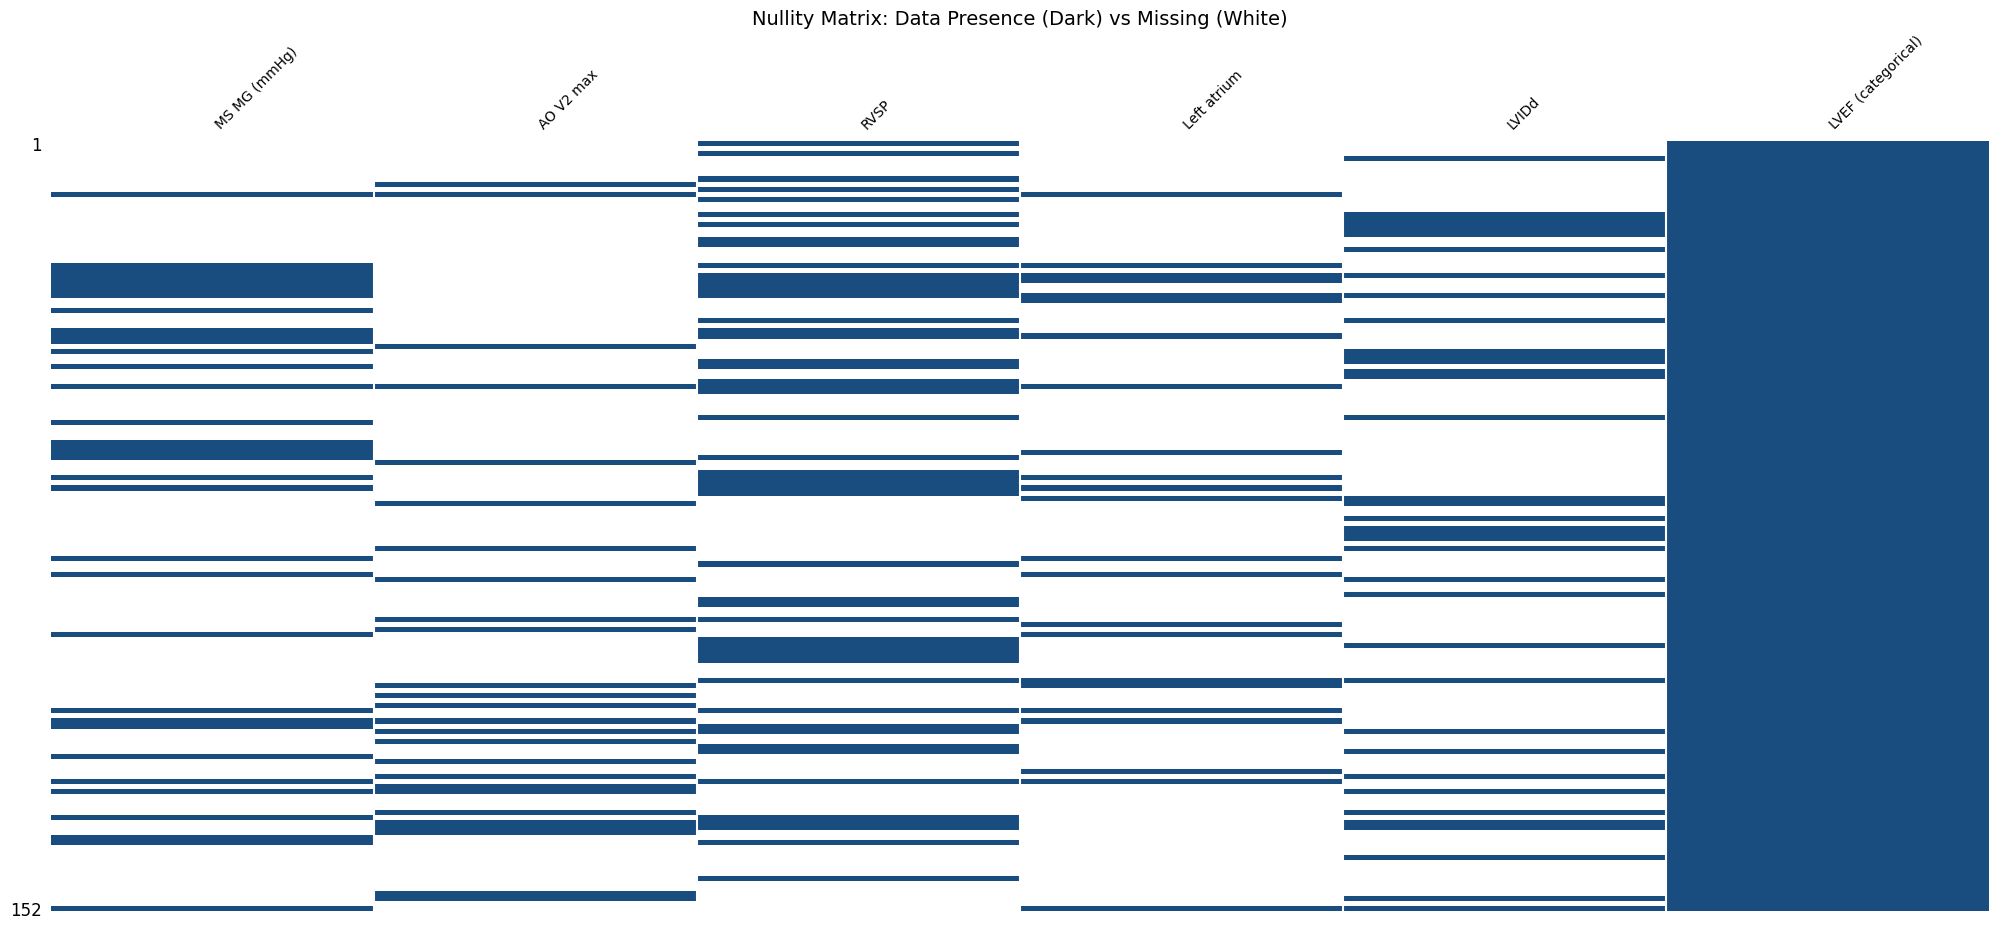

Note: Correlation of Missingness (1.0 = Always missing together):


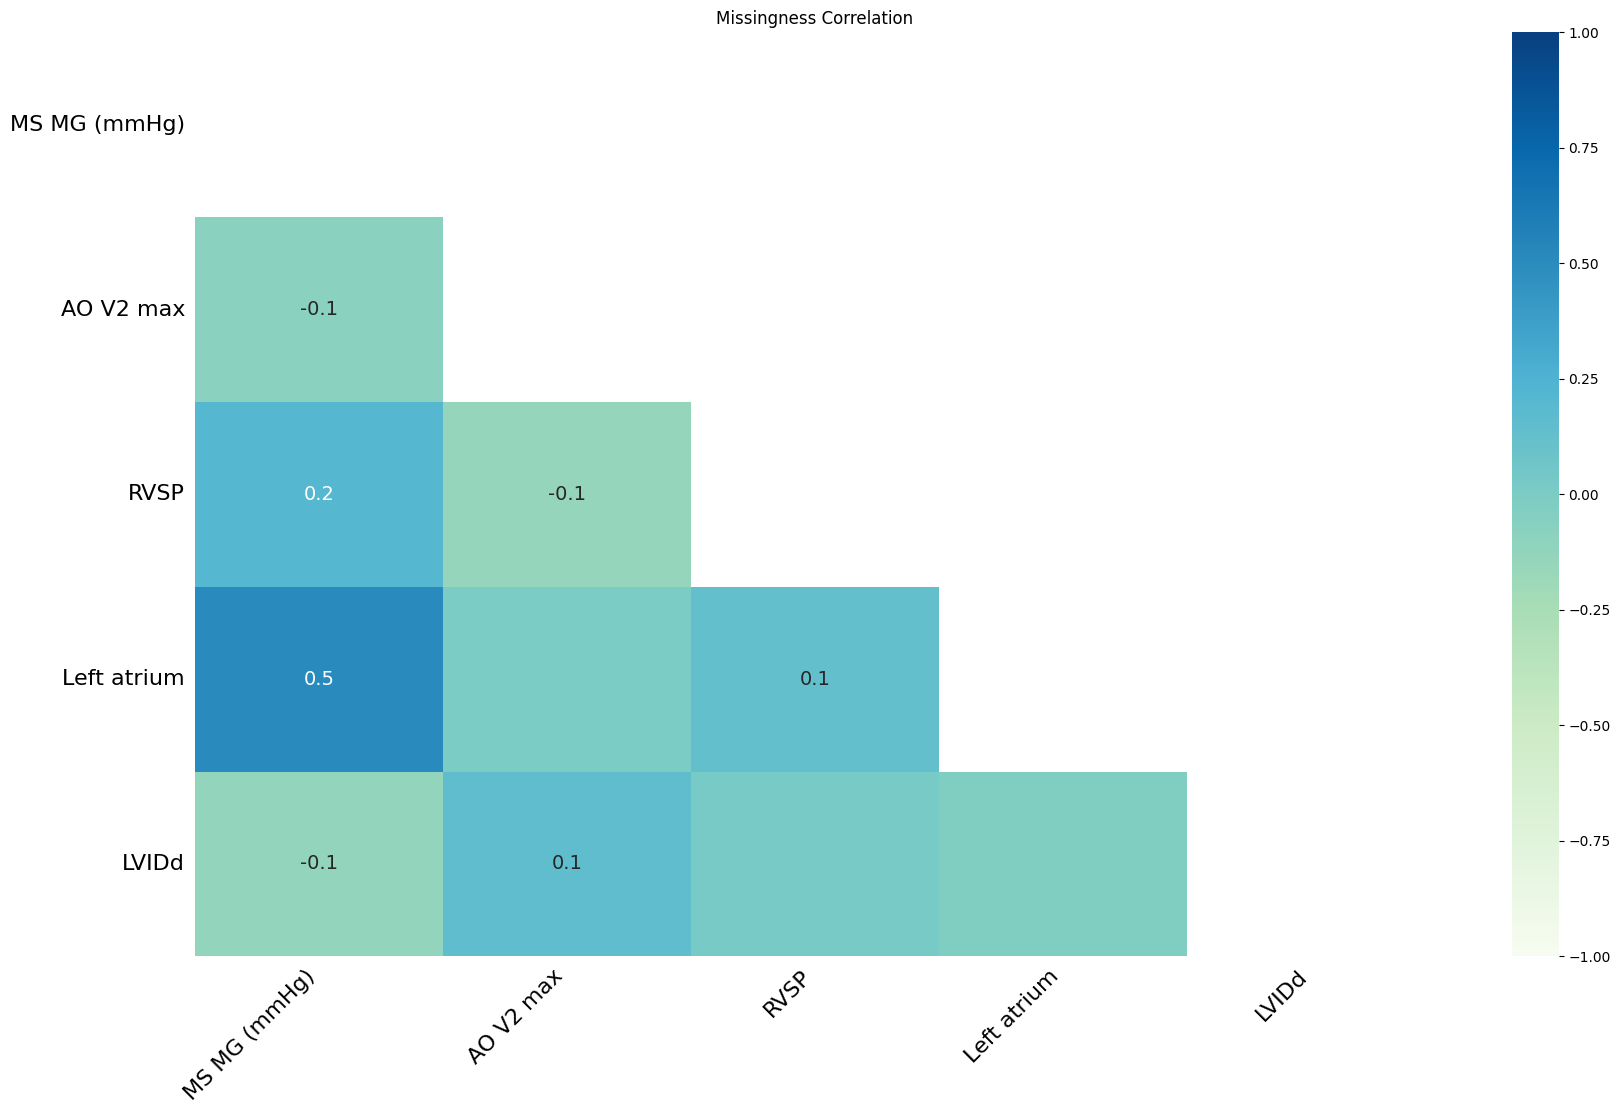


Echocardiogram Triage Matrix notes:
----------------------------------------
A 'Hot' cell (High %) indicates a parameter the cardiologist deemed mandatory for triage.


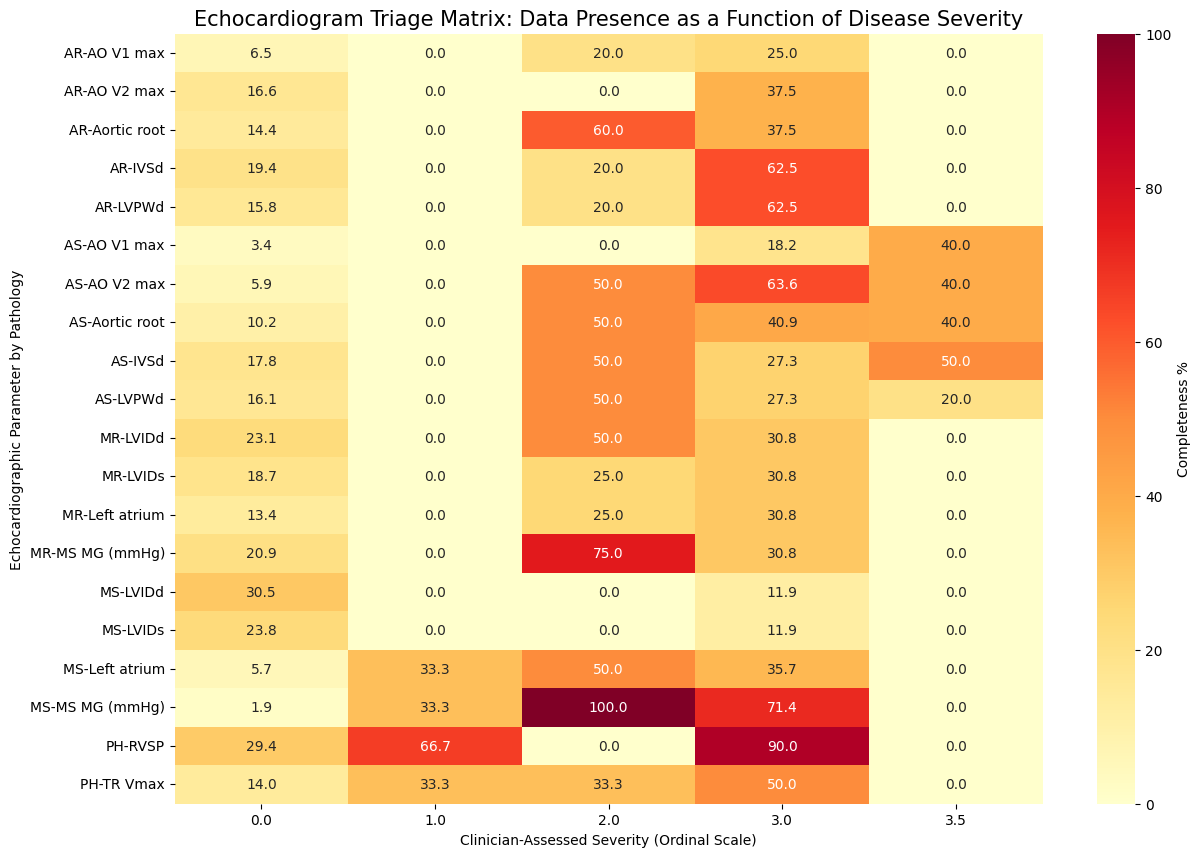

In [76]:
# Sync Auditor and Print Full Triage Matrix
missingness_matrix = auditor.echo_missingness() 
display(missingness_matrix)

viz.patient_nullity()
viz.echo_matrix(missingness_matrix)

In [77]:
# PHASE 2: Clinical Baseline & Prevalence
# ==========================================
print(f"PHASE 2: Clinical baseline & prevalence\n{'='*40}")
extractor.baseline()
extractor.disease_profiler()

print(f"\nDisease prevalence: (n={len(df)})\n" + '-'*40)
prevalence = extractor.diagnoses_prevalence()
display(prevalence.head(10))

print("\nDisease complexity\n" + '-'*40)
for key, value in extractor.complexity_stats.items():
    print(f"{key}:  {value}")

PHASE 2: Clinical baseline & prevalence
Baseline characteristics
----------------------------------------


,Value,Completeness,Type
Characteristic,,,
Age,47.1 ± 15.7,100.0%,Continuous
Gender,Mode: Female (64.5%),100.0%,Categorical
Weight,71.6 ± 16.2,98.0%,Continuous
Height,4.0 ± 15.5,98.0%,Continuous
OSat,94.9 ± 9.6,99.3%,Continuous
SBP R,124.6 ± 18.7,100.0%,Continuous
DBP R,76.7 ± 12.5,100.0%,Continuous
Heart rate,76.6 ± 14.1,100.0%,Continuous



Disease prevalence: (n=152)
----------------------------------------


,Patient Count,Prevalence (%)
Diagnosis,,
Mitral stenosis,49,32.2
Aortic stenosis,34,22.4
Secundum atrial septal defect,22,14.5
Mitral regurgitation,19,12.5
Pulmonary hypertension,15,9.9
Aortic regurgitation,15,9.9
Surgical aortic valve replacement,14,9.2
Bicuspid aortic valve,12,7.9
Mitral valve percutaneous valvuloplasty,11,7.2



Disease complexity
----------------------------------------
Total Patients:  152
Mixed Mitral:  7
Mixed Aortic:  1
Multi-Valvular:  8
Significant PH (>=2.0):  13
AFib Present:  7


In [78]:
# PHASE 3: Statistical Imputation & MBI
# ==========================================
print(f"\nPHASE 3: Statistical Imputation & MBI\n{'='*40}")
stats.apply_imputation()
calc.medication_index().head(5)


PHASE 3: Statistical Imputation & MBI
Handled MS MG (mmHg) using 'Natural Normal' distribution.
Handled AO V2 max using 'Natural Normal' distribution.
Handled RVSP using 'Natural Normal' distribution.
Handled LVIDd using 'Natural Normal' distribution.


,Age,Gender,Pre-procedure diagnosis,Post-procedure diagnosis,Year(s) since procedure,Medications,SBP R,DBP R,Heart rate,OSat,...,PH_Present,PH_Significant,Has_Shunt,AFib_Present,Complexity_Score,MS MG (mmHg)_Imputed,AO V2 max_Imputed,RVSP_Imputed,LVIDd_Imputed,MBI
0,30,Male,"Bicuspid aortic valve, Secundum atrial septal ...",NaN,NaN,Tadalafil 20 mg QD | Metoprolol 50 mg QD | Spi...,98,63,67,97.0,...,0,0,1,0,0,2.0,1.1,40.0,4.2,2.00
1,20,Female,Secundum atrial septal defect,NaN,NaN,Aspirin 100 mg QD,118,68,58,99.0,...,0,0,1,0,0,1.7,0.9,22.1,4.6,1.00
2,73,Female,"Left atrium thrombus, Moderate tricuspid regur...",NaN,NaN,Irbesartan 159 mg QD | Carvedilol 6.25 mg QD |...,144,93,63,89.0,...,0,0,0,0,0,1.6,1.0,72.0,4.1,2.31
3,15,Female,"Arrhythmogenic right ventricle dysplasia, Prim...",NaN,NaN,Sildenafil 25 mg BID,105,70,105,93.0,...,1,1,0,0,1,1.0,1.2,24.4,4.2,2.50
4,18,Male,Mild intracavitary right ventricle muscle bund...,NaN,NaN,NaN,132,78,99,98.0,...,0,0,0,0,0,1.0,1.4,24.0,4.4,0.00


PHASE 4: Visualizing clinical complexity and imputation Data

Complexity frequency and stratification
----------------------------------------


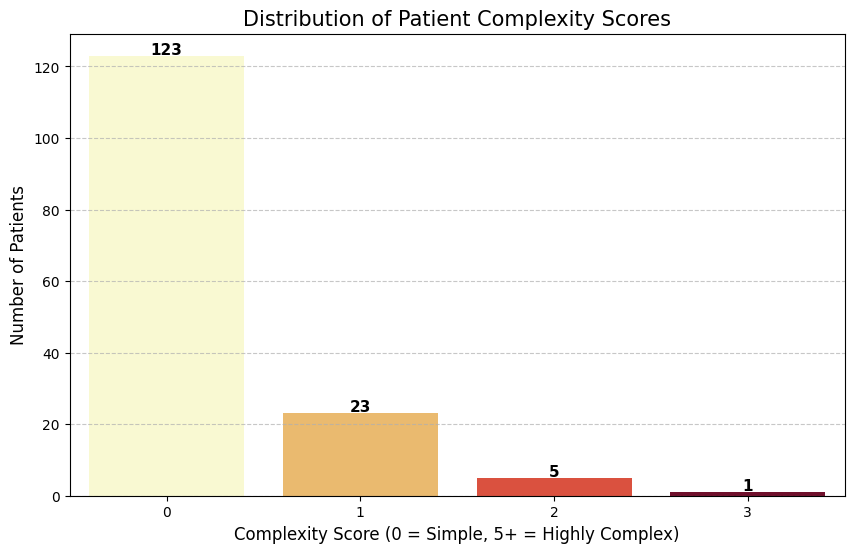

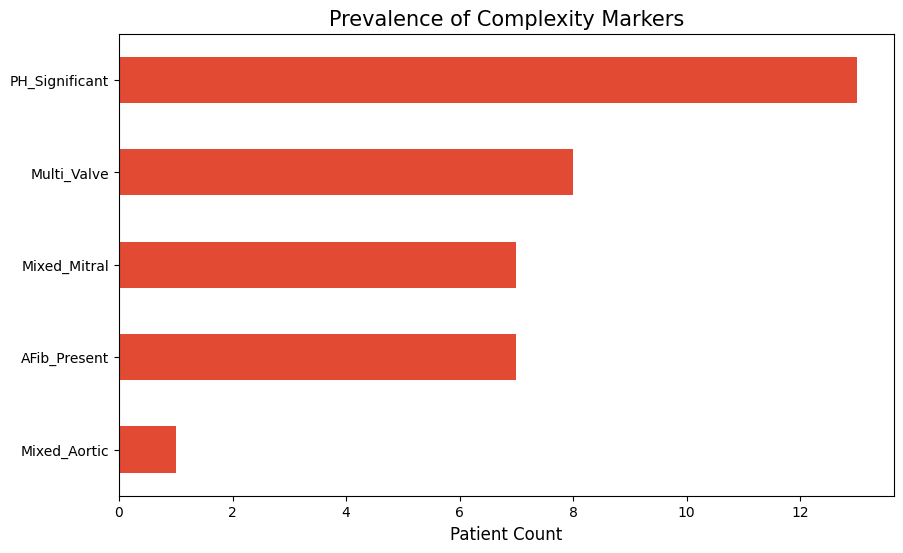

Echo parameters heatmap interaction
----------------------------------------


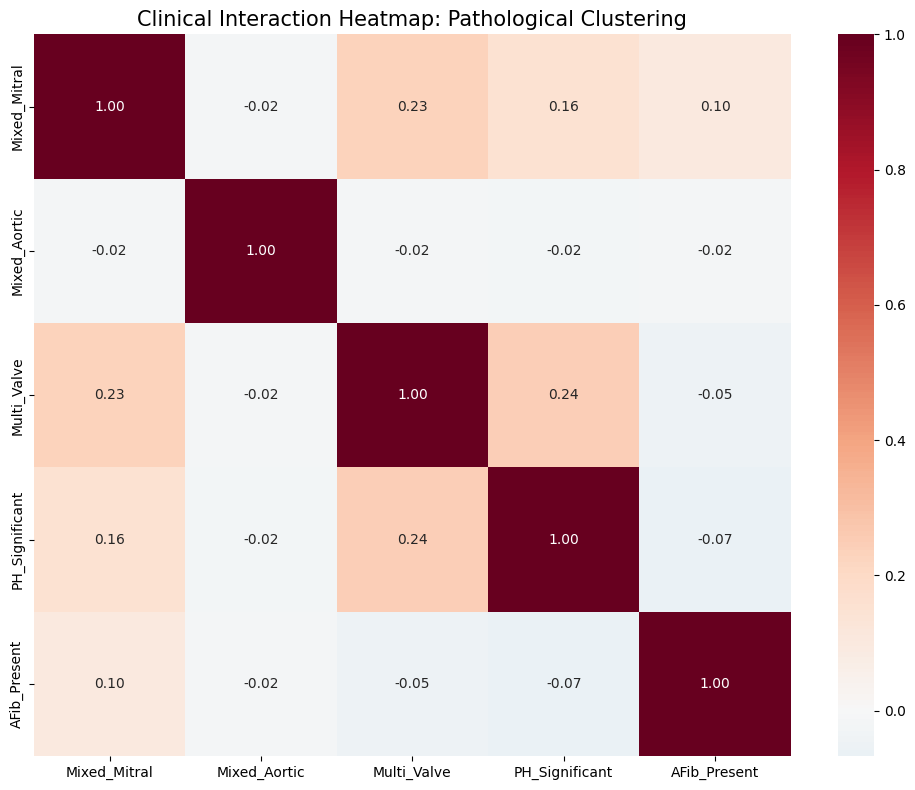

Sensitivity analysis for the Stochastic Imputation
----------------------------------------


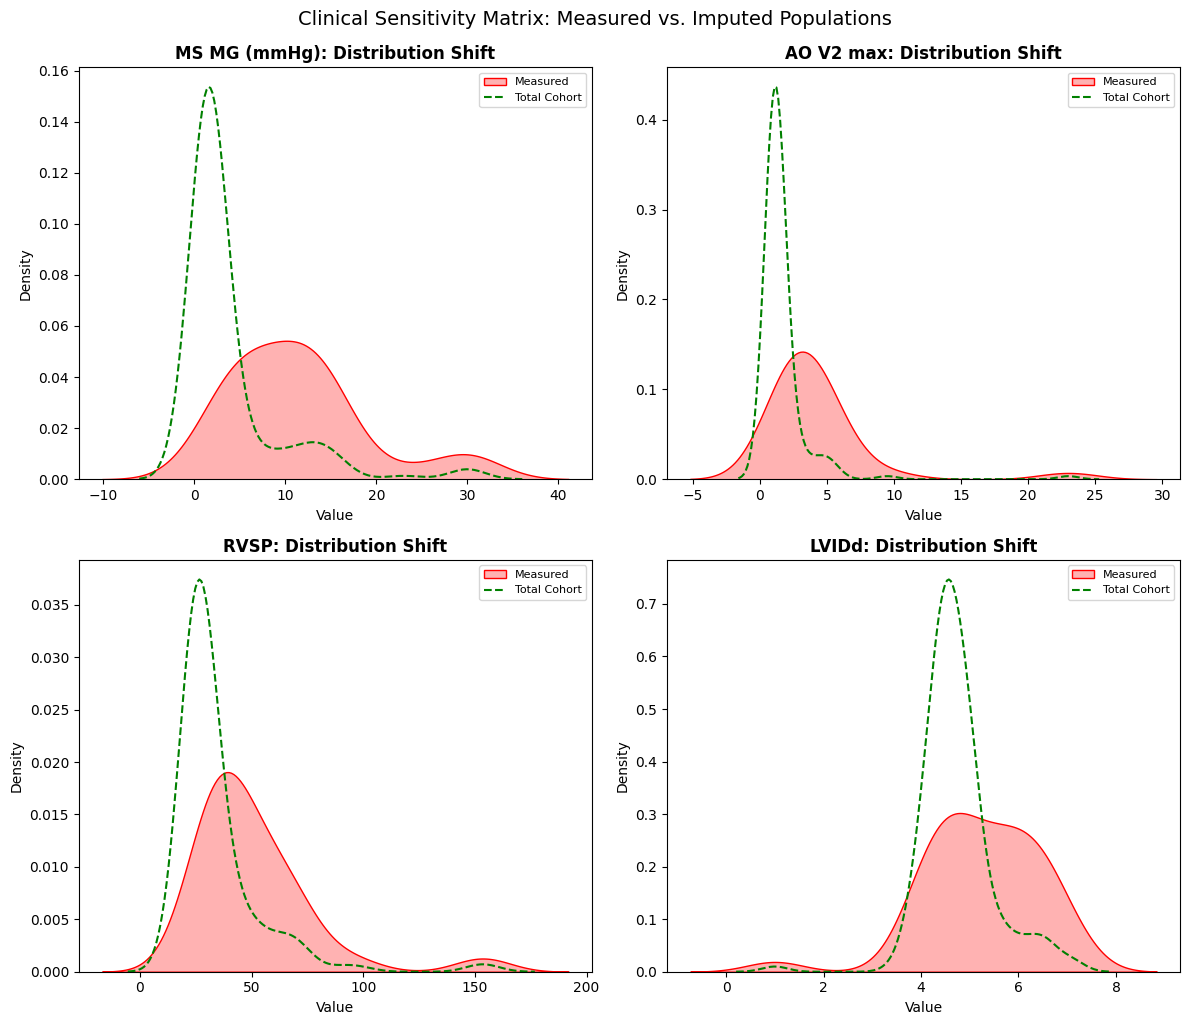

,Measured Mean,Cohort Mean,Delta (Shift),Triage Bias,Sample Size (n)
Clinical Parameter,,,,,
MS MG (mmHg),11.4,3.8,-7.6,Significant Shift,35
AO V2 max,4.3,1.7,-2.6,Significant Shift,26
RVSP,51.0,34.2,-16.8,Significant Shift,51
LVIDd,5.2,4.7,-0.5,Stable,37


ROC visualization for MBI
----------------------------------------


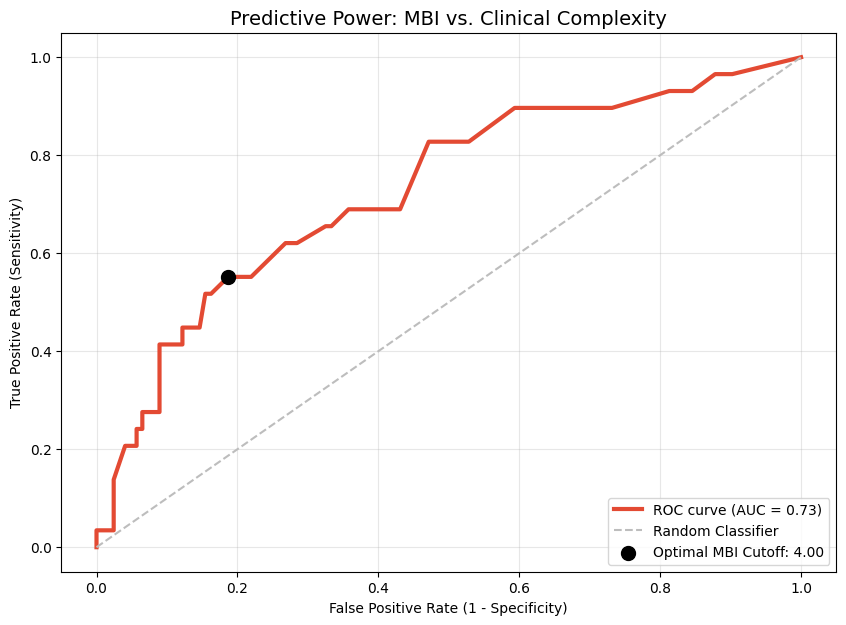

Analysis Complete: A value of MBI above 4.00 is the best predictor of patient complexity.

MBI Threshold Validation (> 4.0)
----------------------------------------
F1-Score:  0.421
Precision: 0.800 (Reliability: When MBI is high, is the patient actually sick?)
Recall:    0.286 (Sensitivity: Does MBI catch all the sick patients?)

Confusion matrix visualization
----------------------------------------


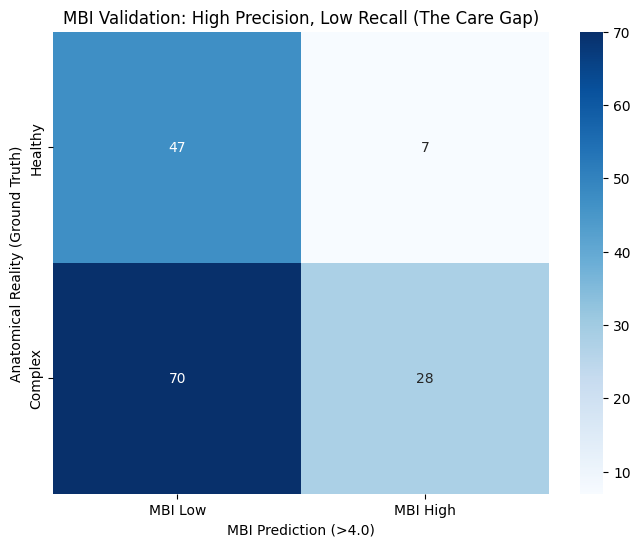

Global MBI burden, stratified by medication classes
----------------------------------------


Bars represent **aggregate population burden**    
Color indicate **clinical priority** weights


KEY MBI FINDINGS SUMMARY: PHARMACOLOGICAL DRIVERS
Total Cohort Burden Score: 434.9

TOP 3 CLINICAL DRIVERS:
1. Anticoagulants_Antiplatelets | Burden:  90.5 (20.8%)
   - Dominant Medication: Aspirin (47.5% of class)
2. RAAS_Inhibitors           | Burden:  69.2 (15.9%)
   - Dominant Medication: Losartan (55.3% of class)
3. Beta_Blockers             | Burden:  68.3 (15.7%)
   - Dominant Medication: Carvedilol (49.1% of class)



In [79]:
# PHASE 4: Visualizing Clinical Complexity, Imputation Data and MBI validity
# ==========================================
print(f"PHASE 4: Visualizing clinical complexity and imputation Data\n{'='*40}")

viz = Visualizer(df, config)
stats.df = df

# Complexity Analysis
print("\nComplexity frequency and stratification\n" + '-'*40)
viz.complexity_frequency()
viz.complexity_markers()
print("Echo parameters heatmap interaction\n" + '-'*40)
viz.complexity_heatmap()

# Sensitivity analysis
print("Sensitivity analysis for the Stochastic Imputation\n" + '-'*40)
viz.sensitivity_grid()
sensitivity_table = stats.sensitivity_report()
display(sensitivity_table)

# ROC analysis
stats.roc(predictor_col='MBI')

# Validation of the MBI threshold
# 2.0 for a moderate cutoff
anatomical_threshold = 2.0 
df['Is_Complex_Anatomic'] = (df[config.lesions_anatomic].max(axis=1) >= anatomical_threshold).astype(int)

# Apply the MBI Cutoff (The Predictor)
mbi_cutoff = 4.0
df['MBI_Predicted_High'] = (df['MBI'] > mbi_cutoff).astype(int)
matrix = stats.validate_predictor(mbi_cutoff)
viz.validate_vis(matrix, 
                 'MBI Prediction (>4.0)', 'Anatomical Reality (Ground Truth)', 
                 'MBI Validation: High Precision, Low Recall (The Care Gap)'
)
mbi_decomposed = viz.predictor_decomposition()

In [80]:
# PHASE 5: Regression for mismatches
# ==========================================
# df.columns.tolist()
# stats.match_regression()

# Variables to be used for regression
regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
regression_demographics = ['Age', 'Weight', 'Gender_Male', 'SBP R', 'DBP R', 'Heart rate']
regression_lesions = ['Mitral_Mixed_Score', 'Aortic_Mixed_Score', 'Multi_Valve', 'Sev_PH', 'AFib_Present']

mbi_mismatch = stats.run_regression(y_var='MBI')


CROSS-STRATA COMPARISON: MBI


,Native Coef,Percutaneous Coef,Surgical Coef
const,-0.508,37.770 *,-
Age,0.027 **,0.172 **,-0.008
Weight,0.038 ***,-0.093,-0.023
SBP R,-0.022 *,-0.004,0.075
DBP R,0.002,-0.095,-0.025
Heart rate,-0.004,-0.019,0.005
Multi_Valve,0.345,-0.000 *,-0.971
Sev_PH,0.665 ***,-0.000 *,0.000
AFib_Present,1.561 *,-0.000 *,0.774
RVSP_Imputed,0.025 ***,-0.019,0.124


In [ ]:
mbi_mismatch_native = stats.run_regression(y_var='MBI', strata='Native')


DEEP DIVE: MBI NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:                    MBI   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     4.137
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           0.000264
Time:                        09:28:03   Log-Likelihood:                -225.14
No. Observations:                 110   AIC:                             468.3
Df Residuals:                     101   BIC:                             492.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
c

In [ ]:
# We slice PH since due to collinearity
regression_lesions = ['Mitral_Mixed_Score', 'Aortic_Mixed_Score', 'Multi_Valve', 'AFib_Present']
regression_demographics = ['Age', 'Weight', 'Gender_Male', 'SBP R', 'DBP R', 'Heart rate', 'MBI']

# Running regression by regression_echo columns
for var in regression_echo:
    print(f"\n--- STARTING AUTOMATED AUDIT FOR: {var} ---")
    stats.run_regression(y_var=var, strata='Native')


--- STARTING AUTOMATED AUDIT FOR: RVSP_Imputed ---

DEEP DIVE: RVSP_Imputed NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:           RVSP_Imputed   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     2.629
Date:                Wed, 31 Dec 2025   Prob (F-statistic):            0.00354
Time:                        09:32:22   Log-Likelihood:                -480.49
No. Observations:                 110   AIC:                             989.0
Df Residuals:                      96   BIC:                             1027.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [98]:
regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
regression_demographics = ['Age', 'Weight', 'Gender_Male', 'SBP R', 'DBP R', 'Heart rate']
regression_lesions = ['Mitral_Mixed_Score', 'Aortic_Mixed_Score', 'Sev_PH', 'AFib_Present']

mbi_mismatch = stats.run_regression(y_var='MS MG (mmHg)_Imputed', strata='Native')


DEEP DIVE: MS MG (mmHg)_Imputed NATIVE (n=110)
                             OLS Regression Results                             
Dep. Variable:     MS MG (mmHg)_Imputed   R-squared:                       0.425
Model:                              OLS   Adj. R-squared:                  0.354
Method:                   Least Squares   F-statistic:                     5.987
Date:                  Wed, 31 Dec 2025   Prob (F-statistic):           1.03e-07
Time:                          09:38:50   Log-Likelihood:                -314.07
No. Observations:                   110   AIC:                             654.1
Df Residuals:                        97   BIC:                             689.2
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [99]:
regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LA_Size_Score', 'LVEF_Score']
regression_demographics = ['Age', 'Weight', 'Gender_Male', 'SBP R', 'DBP R', 'Heart rate']
regression_lesions = ['Mitral_Mixed_Score', 'Aortic_Mixed_Score', 'Sev_PH', 'AFib_Present']

mbi_mismatch = stats.run_regression(y_var='LA_Size_Score', strata='Native')


DEEP DIVE: LA_Size_Score NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:          LA_Size_Score   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     5.085
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           1.61e-06
Time:                        09:39:32   Log-Likelihood:                -144.72
No. Observations:                 110   AIC:                             315.4
Df Residuals:                      97   BIC:                             350.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [100]:
regression_echo = ['RVSP_Imputed', 'LVIDd_Imputed', 'AO V2 max_Imputed', 'MS MG (mmHg)_Imputed', 'LVEF_Score']
regression_demographics = ['Age', 'Weight', 'Gender_Male', 'SBP R', 'DBP R', 'Heart rate']
regression_lesions = ['Mitral_Mixed_Score', 'Aortic_Mixed_Score', 'Sev_PH', 'AFib_Present']

mbi_mismatch = stats.run_regression(y_var='Multi_Valve', strata='Native')


DEEP DIVE: Multi_Valve NATIVE (n=110)
                            OLS Regression Results                            
Dep. Variable:            Multi_Valve   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     3.220
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           0.000642
Time:                        09:40:17   Log-Likelihood:                 25.422
No. Observations:                 110   AIC:                            -24.84
Df Residuals:                      97   BIC:                             10.26
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [83]:
# df_residuals = stats.calculate_residuals()

#  # --- 3. PLOT RESIDUALS PER VALVE STATUS ---
# fig = px.violin(
#     df_residuals, x='Approach', y='MBI_Mismatch', color='Approach',
#     box=True, points="all", template='plotly_white',
#     title="Clinical Mismatch Index: MBI Residuals by Approach",
#     labels={'MBI_Mismatch': 'Prescribing Mismatch (Actual MBI - Predicted MBI)'}
# )
# fig.add_hline(y=0, line_dash="dash", line_color="black", annotation_text="Standard of Care")
# fig.show()

In [84]:
# stats.rvsp_hemodynamics()
# viz.hemodynamic_failure()

In [85]:
# PHASE 6: Executive Summary
# ==========================================
print(f"\nPHASE 5: Executive Summary\n{'='*40}")
total = len(df)
# Note: Is_Complex_Case was created inside stats.roc()
high_risk_n = df['Is_Complex_Case'].sum()
high_risk_pct = (high_risk_n / total) * 100
avg_mbi = df['MBI'].mean()

print(f"TOTAL PATIENTS:         {total}")
print(f"HIGH-RISK CASES:        {high_risk_pct:.1f}% (n={high_risk_n})")
print(f"AVG MEDICATION BURDEN:  {avg_mbi:.2f}")

print(f"\nDISEASE PREVALENCE SUMMARY:\n" + '-' * 40)
display(prevalence.head(10))

print("\nDISEASE COMPLEXITY BREAKDOWN:\n" + '-'*40)
for key, value in extractor.complexity_stats.items():
    print(f"{key}:  {value}")


PHASE 5: Executive Summary
TOTAL PATIENTS:         152
HIGH-RISK CASES:        19.1% (n=29)
AVG MEDICATION BURDEN:  2.86

DISEASE PREVALENCE SUMMARY:
----------------------------------------


,Patient Count,Prevalence (%)
Diagnosis,,
Mitral stenosis,49,32.2
Aortic stenosis,34,22.4
Secundum atrial septal defect,22,14.5
Mitral regurgitation,19,12.5
Pulmonary hypertension,15,9.9
Aortic regurgitation,15,9.9
Surgical aortic valve replacement,14,9.2
Bicuspid aortic valve,12,7.9
Mitral valve percutaneous valvuloplasty,11,7.2



DISEASE COMPLEXITY BREAKDOWN:
----------------------------------------
Total Patients:  152
Mixed Mitral:  7
Mixed Aortic:  1
Multi-Valvular:  8
Significant PH (>=2.0):  13
AFib Present:  7


In [86]:
# # EXPLORATIONS
# # ==========================================

In [87]:
# # 6. CODE DRAFT
# # ==========================================

# # 1. PHENOTYPIC MATRIX CONSTRUCTION (Goal 1)
# # ---------------------------------------------------------
# # We assume 'df' contains your normalized [0-4] lesion columns.
# lesion_cols = ['ms_norm', 'mr_norm', 'as_norm', 'ar_norm']
# # Create Interaction Terms for 'Double Lesions'
# df['mitral_interaction'] = df['ms_norm'] * df['mr_norm']
# df['aortic_interaction'] = df['as_norm'] * df['ar_norm']

# # 2. MBI VALIDATION & THRESHOLDING (Goal 3)
# # ---------------------------------------------------------
# # Validating the 4.0 threshold against a 'Complexity_High' binary flag
# df['Complexity_High'] = (df['Complexity_Score'] >= 2).astype(int) 
# df['MBI_Flag'] = (df['MBI'] >= 4.0).astype(int)

# f1 = f1_score(df['Complexity_High'], df['MBI_Flag'])
# print(f"Goal 3 - F1 Score for MBI Threshold (4.0): {f1:.2f}")

# # 3. INTERACTION MODEL & DECOMPOSED RESIDUALS (Goal 4)
# # ---------------------------------------------------------
# # Defining the Model: Y = MS + MR + (MS*MR) + AS + AR + (AS*AR) + AFib
# X = df[['ms_norm', 'mr_norm', 'mitral_interaction', 
#         'as_norm', 'ar_norm', 'aortic_interaction', 'afib_flag']]
# X = sm.add_constant(X)
# y = df['MBI'] # Using MBI as the dependent variable to find 'mismatches'

# model = sm.OLS(y, X).fit()
# df['Predicted_MBI'] = model.predict(X)
# df['MBI_Residual'] = df['MBI'] - df['Predicted_MBI']

# # 4. STRATEGIC TRIAGE FILTERING: THE SWEET SPOT (Goal 5)
# # ---------------------------------------------------------
# # 'Sweet Spot' = Significant Anatomy but not yet 'Palliative'
# # We filter out patients with extreme RVSP (e.g., > 70) as Palliative
# palliative_threshold_rvsp = 70

# df['Triage_Status'] = 'Candidate'
# df.loc[df['rvsp_imputed'] > palliative_threshold_rvsp, 'Triage_Status'] = 'Palliative/High-Risk'
# df.loc[df['Complexity_Score'] < 1, 'Triage_Status'] = 'Low Priority'

# # The 'Interventional Priority' are those with High Negative Residuals 
# # (Meaning: High anatomical disease but surprisingly low medication burden)
# triage_list = df[df['Triage_Status'] == 'Candidate'].sort_values(by='MBI_Residual', ascending=True).head(20)

# # 5. FINAL EXPORT (Excel & Summary)
# # ---------------------------------------------------------
# def export_results(full_df, triage_df):
#     with pd.ExcelWriter("PHL_2025_Final_Triage_Report.xlsx", engine='xlsxwriter') as writer:
#         triage_df.to_excel(writer, sheet_name='Strategic_Triage_List', index=False)
#         full_df.to_excel(writer, sheet_name='Full_Phenotypic_Matrix', index=False)
#     print("Goal 5 - Strategic Triage List Exported to Excel.")

# export_results(df, triage_list)
# print(model.summary())

In [88]:
# 6. LOG OF CURRENT STATUS OF CODE
# ==========================================
file = 'phl_2025.ipynb'
os.system(f"jupyter nbconvert --to markdown {file}")
print(f"Success! Markdown file generated: {file.replace('.ipynb', '.md')}")


Success! Markdown file generated: phl_2025.md
